<h1><b><center>CLASIFICACIÓN DE NORMALIDAD EN TEJIDO DE MAMAS A PARTIR DE IMÁGENES DIGITALES DE RAYOS X</center></h1>

|<h2><font color='white'>-----------------------</font><b>DIEGO FERNANDO VELASCO GIRALDO||
|---|---|
|||
|||
| <left><font size="4">Estudiante de Maestría en Ingeniería con Énfasis en Ingeniería Electrónica</font> | <center><img src="https://drive.google.com/uc?id=1CtdK5Litx2pQmTGD3U2Qs0MxIVs_nB8H" width="55" height="80" /> |
|||
| <left><font size="4">Grupo de Investigación Percepción y Sistemas Inteligentes - Univalle</font> | <center><img src="https://drive.google.com/uc?id=1qEQd1k3SOIeLx-X0OSYQ0DosajsIy9Vc" width="165" height="70" /> |
|||
| <left><i><font size="4">Correo Electrónico: diego.fernando.velasco@correounivalle.edu.co</font></i> | <center><i><font size="4">Celular: 3234777477</font></i> |
|||

<center><h4><i>Proyecto de Grado - Modalidad: Profundización - Universidad del Valle - Director: Humberto Loaiza, Ph.D.</i></h4>
<br>

##<b> Librerías necesarias: </b>

In [ ]:
# import the necessary packages
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import argparse
import cv2
import glob
from pandas import DataFrame
import sklearn
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from scipy import stats
import operator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

##<b> Montaje de unidad Google Drive en el entorno de ejecución: </b>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Implementación Proyecto Grado Maestría

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Implementación Proyecto Grado Maestría


##<b> Verificación presencia de GPU: </b>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
'''
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
'''

'\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\nprint("Num GPUs Available: ", len(physical_devices))\ntf.config.experimental.set_memory_growth(physical_devices[0], True)\n'

<h1><b><center>DATA WRANGLING</center></h1>

##<b> Carga de dataframe descriptivo del mini-MIAS dataset: </b>

La siguiente lista muestra los nombres de las imágenes en la base de datos mini-MIAS y proporciona los detalles correspondientes de la siguiente manera:

<p>
<i>
1st column:
MIAS database reference number.

2nd column:
Character of background tissue:
  F  Fatty
  G  Fatty-glandular
  D  Dense-glandular

3rd column:
Class of abnormality present:
  CALC  Calcification
  CIRC  Well-defined/circumscribed masses
  SPIC  Spiculated masses
  MISC  Other, ill-defined masses
  ARCH  Architectural distortion
  ASYM  Asymmetry
  NORM  Normal

4th column:
Severity of abnormality;
  B  Benign
  M  Malignant

5th, 6th columns:
x,y image-coordinates of centre of abnormality.
7th column:
Approximate radius (in pixels) of a circle enclosing the abnormality.
There are also several things you should note:

The list is arranged in pairs of films, where each pair represents the left (even filename numbers) and right mammograms (odd filename numbers) of a single patient.
The size of all the images is 1024 pixels x 1024 pixels. The images have been centered in the matrix.
When calcifications are present, centre locations and radii apply to clusters rather than individual calcifications. Coordinate system origin is the bottom-left corner.
In some cases calcifications are widely distributed throughout the image rather than concentrated at a single site. In these cases centre locations and radii are inappropriate and have been omitted.

Hay 330 imágenes en total: En la tabla de metadatos aparecen indicadas 322 porque algunas imágenes tienen más de una anomalía sea benigna o maligna.

Las que figuran más de una vez son:

mdb005: 2 veces

mdb132: 2 veces

mdb144: 2 veces (B y M)

mdb223: 2 veces

mdb226: 3 veces

mdb239: 2 veces

mdb249: 2 veces
</i>
</p>

In [ ]:
'''
Hay 330 imágenes en total: En la tabla de metadatos aparecen indicadas 322 porque algunas imágenes tienen más de una anomalía sea benigna o maligna.
Las que figuran más de una vez son:
mdb005 2 veces
mdb132 2 veces
mdb144 2 veces (B y M)
mdb223 2 veces
mdb226 3 veces
mdb239 2 veces
mdb249 2 veces
'''
dataPath = "all-mias"
textFile = os.path.join(dataPath,"miasInfo.txt")
mias_df = pd.read_csv(textFile, sep=" ", header=0)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


<b> Reemplazo (llenado) de valores vacíos o nulos: </b>

In [ ]:
values = {"SEVERITY": 'N', "X": 0, "Y": 0, "RADIUS": 0}
mias_df = mias_df.fillna(value=values)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,N,0.0,0.0,0.0
3,mdb004,D,NORM,N,0.0,0.0,0.0
4,mdb005,F,CIRC,B,477.0,133.0,30.0


##<b> Cambio de números decimales a enteros: </b>

In [ ]:
mias_df.X = mias_df.X.astype(int)
mias_df.Y = mias_df.Y.astype(int)
mias_df.RADIUS = mias_df.RADIUS.astype(int)
mias_df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535,425,197
1,mdb002,G,CIRC,B,522,280,69
2,mdb003,D,NORM,N,0,0,0
3,mdb004,D,NORM,N,0,0,0
4,mdb005,F,CIRC,B,477,133,30


##<b> Visualización de cantidad de anormalidades según el tipo: </b>

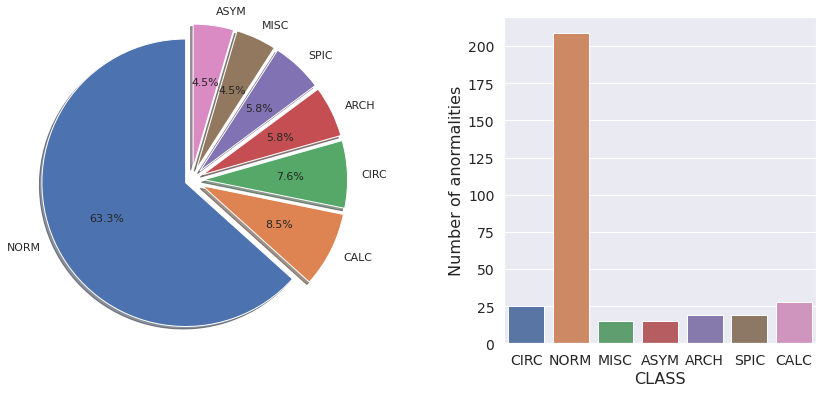

Número de anomalías normales: 209
Número de anomalías anormales: 121


In [ ]:
fig = plt.figure()
fig.suptitle("", fontsize=16)

ax = fig.add_subplot(1,2,1)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
mias_df['CLASS'].value_counts().plot(kind='pie',
                                   figsize=(14, 6),
                                   autopct='%1.1f%%', # add in percentages
                                   startangle=90,     # start angle 90°
                                   shadow=True,       # add shadow
                                   explode=[0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                                   fontsize=11, radius=1.15)
ax.set_ylabel('')


ax = fig.add_subplot(1,2,2)
ax = sns.countplot(x="CLASS", data=mias_df)
ax.set_xlabel("CLASS",fontsize=16)
ax.set_ylabel("Number of anormalities",fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
# plt.grid(False)
plt.show()


number_of_normal = sum(targ == 'NORM' for targ in mias_df.CLASS)
print("Número de anomalías normales:",number_of_normal)
number_of_abnormal = sum(targ != 'NORM' for targ in mias_df.CLASS)
print("Número de anomalías anormales:",number_of_abnormal)

##<b> Visualización de cantidad de anormalidades benignas, malignas y normales: </b>

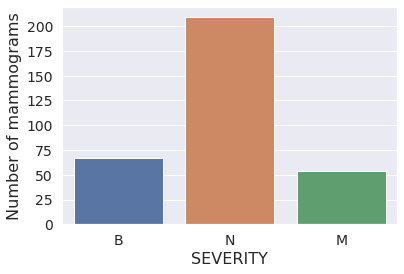

In [ ]:
ax = sns.countplot(x="SEVERITY", data=mias_df)
ax.set_xlabel("SEVERITY",fontsize=16)
ax.set_ylabel("Number of mammograms",fontsize=16)
plt.xticks(size = 14)
plt.yticks(size = 14)
# plt.grid(False)
plt.show()

##<b> Visualización en diagrama de caja de las severidades (benignas o malignas) vs. el radio de las mismas: </b>

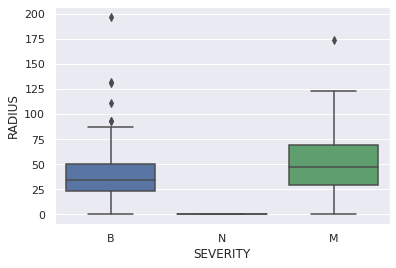

In [ ]:
ax = sns.boxplot(x="SEVERITY", y="RADIUS", data=mias_df)

##<b>Separación de variables cualitativas categóricas nominales y variables numéricas cuantitativas: </b>

In [ ]:
'''
Variable cualitativa categórica nominal:  BG, CLASS, SEVERITY
Variable numérica cuantitativa - razón:  X, Y, RADIUS
'''
nominalColumns = ["BG", "CLASS", "SEVERITY"]
numericColumns = ["X", "Y", "RADIUS"]

In [ ]:
from pandas.api.types import CategoricalDtype

# Convert numeric attributes
for col in numericColumns:
    mias_df[col] = pd.to_numeric(mias_df[col], errors='coerce')

# loop to change each column to nominal type
for col in nominalColumns:
    cat_type = CategoricalDtype(categories = None, ordered = False)
    mias_df[col] = mias_df[col].astype(dtype = cat_type)

##<b>Visualización de variables cualitativas categóricas nominales y variables numéricas cuantitativas: </b>

> Bloque con sangría



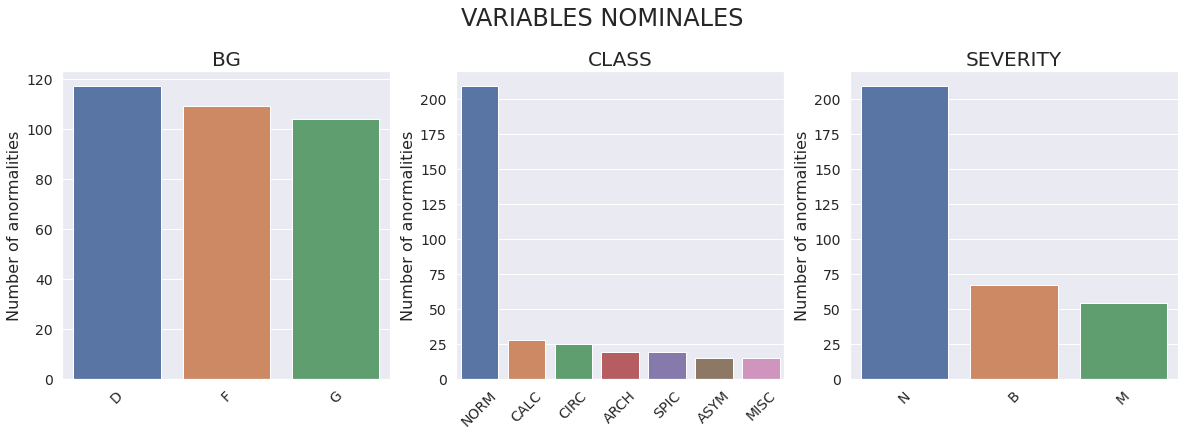

In [ ]:
sns.set()

#Initialize Figure and Axes object
fig, ax = plt.subplots(figsize=(20,30))
fig.suptitle("VARIABLES NOMINALES", fontsize=24)
fig.subplots_adjust(top=0.95, hspace = 0.6)

i=1
for nominalVariable in nominalColumns:
    plt.subplot(4,3,i).set_title(nominalVariable, fontsize=20)
    ax = sns.countplot(nominalVariable, data=mias_df, order = mias_df[nominalVariable].value_counts().index)
    ax.set_xlabel("")
    ax.set_xlabel("")
    ax.set_ylabel("Number of anormalities", fontsize=16)
    plt.xticks(size = 14, rotation=45)
    plt.yticks(size = 14)
    i += 1

plt.show()

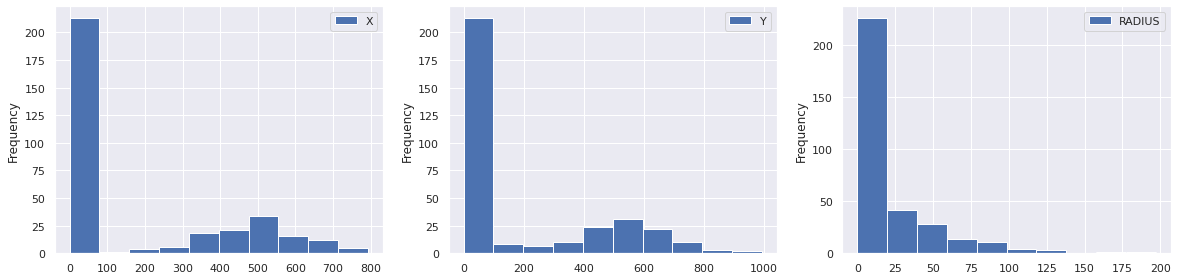

In [ ]:
fig = plt.figure(figsize=(20, 10))

x = 1
# Declarando las graficas de tipo Histograma Variables Númericas
for numericVariable in numericColumns:
    ax = fig.add_subplot(2,3,x)
    mias_df[[numericVariable]].plot(kind='hist', ax=ax, rwidth=1)
    x = x + 1

plt.show()

In [ ]:
#Número de anormalías normales: 207
#Número de anomalías anormales: 123

#Sort data by label value:
# Data = Data.sort_values(by='Target')

#Split by class:
benignClass = mias_df[mias_df.SEVERITY=='B']
print("benignClass before balance shape: ", benignClass.shape)

malignantClass = mias_df[mias_df.SEVERITY=='M']
print("malignantClass before balance shape: ", malignantClass.shape)

normalClass = mias_df[mias_df.SEVERITY=='N']
print("normalClass before balance shape: ", normalClass.shape)

benignClass before balance shape:  (67, 7)
malignantClass before balance shape:  (54, 7)
normalClass before balance shape:  (209, 7)


##<b>Balanceo de datos: </b>

In [ ]:
#Balanceo de datos:

#Undersampling:
benignClass = benignClass.sample(n=57, axis=0, random_state=1)
print("benignClass balanced shape: ", benignClass.shape)

print("malignantClass balanced shape: ", malignantClass.shape)

normalClass = normalClass.sample(n=52, axis=0, random_state=1)
print("normalClass balanced shape: ", normalClass.shape)

mias_df_2 = pd.concat([benignClass, malignantClass, normalClass])
print("mias_df_2 balanced shape:    ",mias_df_2.shape)


#Normalize numeric variables:
#numericColumns = ["X", "Y", "RADIUS"]
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
mias_df_2[['X', 'Y', 'RADIUS']] = min_max_scaler.fit_transform(mias_df_2[['X','Y', 'RADIUS']])

#Split features and labels:
Label = mias_df_2.SEVERITY
Features = mias_df_2.drop(['SEVERITY', 'REFNUM'],axis=1)

#Dummies a las variables nominales
nominalColumns.remove('SEVERITY')
print(nominalColumns)
for nominalVariable in nominalColumns:
    dummies = pd.get_dummies(Features[nominalVariable], prefix = nominalVariable)
    Features = pd.concat([Features.drop(nominalVariable, axis = 1), dummies], axis = 1)

feature_columns = Features.columns

display("benignClass:", benignClass.head())
display("malignantClass:", malignantClass.head())
display("normalClass:", normalClass.head())
display("mias_df_2:", mias_df_2.head())
display("Features:", Features.head())
display("Label:", Label.head())

benignClass balanced shape:  (57, 7)
malignantClass balanced shape:  (54, 7)
normalClass balanced shape:  (52, 7)
mias_df_2 balanced shape:     (163, 7)
['BG', 'CLASS']


'benignClass:'

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
259,mdb252,F,CALC,B,439,367,23
127,mdb127,G,ARCH,B,523,551,48
226,mdb223,D,CALC,B,591,529,6
97,mdb097,F,ASYM,B,612,297,34
126,mdb126,D,ARCH,B,191,549,23


'malignantClass:'

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
23,mdb023,G,CIRC,M,538,681,29
28,mdb028,F,CIRC,M,338,314,56
58,mdb058,D,MISC,M,318,359,27
72,mdb072,G,ASYM,M,266,517,28
75,mdb075,F,ASYM,M,468,717,23


'normalClass:'

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
62,mdb062,D,NORM,N,0,0,0
305,mdb298,F,NORM,N,0,0,0
71,mdb071,G,NORM,N,0,0,0
108,mdb108,D,NORM,N,0,0,0
51,mdb051,G,NORM,N,0,0,0


'mias_df_2:'

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
259,mdb252,F,CALC,B,0.553594,0.369215,0.132184
127,mdb127,G,ARCH,B,0.659521,0.554326,0.275862
226,mdb223,D,CALC,B,0.745271,0.532193,0.034483
97,mdb097,F,ASYM,B,0.771753,0.298793,0.195402
126,mdb126,D,ARCH,B,0.240858,0.552314,0.132184


'Features:'

,X,Y,RADIUS,BG_D,BG_F,BG_G,CLASS_ARCH,CLASS_ASYM,CLASS_CALC,CLASS_CIRC,CLASS_MISC,CLASS_NORM,CLASS_SPIC
259,0.553594,0.369215,0.132184,0,1,0,0,0,1,0,0,0,0
127,0.659521,0.554326,0.275862,0,0,1,1,0,0,0,0,0,0
226,0.745271,0.532193,0.034483,1,0,0,0,0,1,0,0,0,0
97,0.771753,0.298793,0.195402,0,1,0,0,1,0,0,0,0,0
126,0.240858,0.552314,0.132184,1,0,0,1,0,0,0,0,0,0


'Label:'

259    B
127    B
226    B
97     B
126    B
Name: SEVERITY, dtype: category
Categories (3, object): ['B', 'M', 'N']

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(Features, Label, test_size = 0.20)

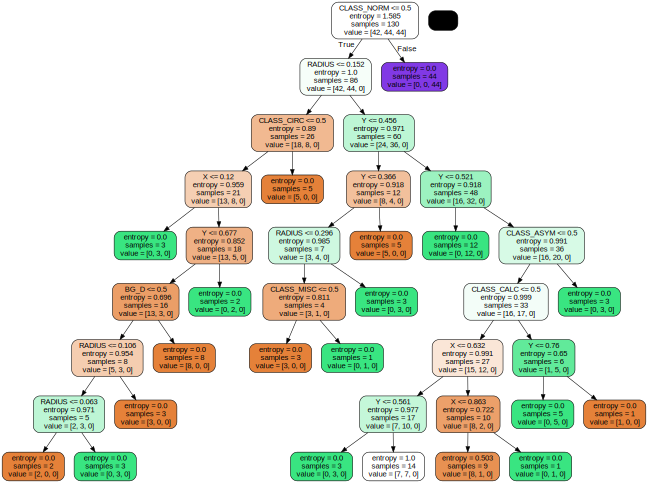

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 8, splitter='best').fit(x_train, y_train) #max_features='sqrt',

y_out = clf.predict(x_test) #Predict class or regression value for X.

#import graphviz
from graphviz import Source
import pydotplus

dot_data = export_graphviz(clf,
                            feature_names=feature_columns,
                            out_file=None,
                            filled=True,
                            rounded=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('original_tree.png')
pydot_graph.set_size('"9,12!"')

gvz_graph = Source(pydot_graph.to_string())

display(gvz_graph)

Confusion Matrix:
 [[8 7 0]
 [6 4 0]
 [0 0 8]]
Accuracy Score:  0.6060606060606061
Max Depth of the Tree:  8


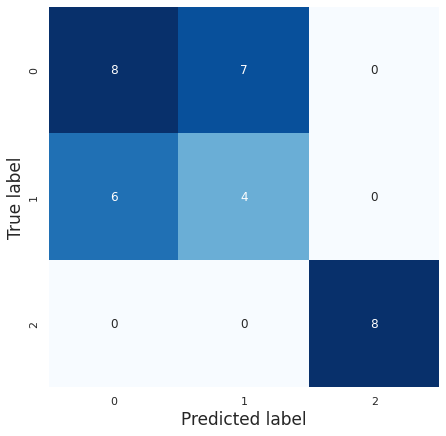

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_out) #(y_true, y_pred)
figsize = (7,7)
fig = plt.figure(figsize=figsize)
heatmap=sns.heatmap(cm, xticklabels=1, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.ylabel('True label', fontsize=17)
plt.xlabel('Predicted label', fontsize=17)
# heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='center', va='center', fontsize=16)
# heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', va='center', fontsize=16)

print("Confusion Matrix:\n",cm)

Score = clf.score(x_test, y_test)
print("Accuracy Score: ",Score)
#Other option: print("Accuracy: ",metrics.accuracy_score(y_test, y_out))

print("Max Depth of the Tree: ",clf.max_depth)

Number of Features:  13


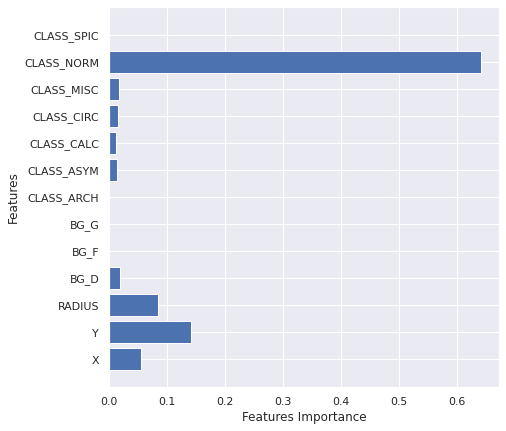

In [ ]:
plt.figure(figsize=(7, 7))
caract=Features.shape[1]
print('Number of Features: ',caract)
plt.barh(range(caract),clf.feature_importances_)
plt.yticks(np.arange(caract), (feature_columns))
plt.xlabel('Features Importance')
plt.ylabel('Features')

plt.show()

Confusion Matrix:
 [[6 9 0]
 [2 8 0]
 [0 0 8]]
Accuracy Score:  0.6666666666666666


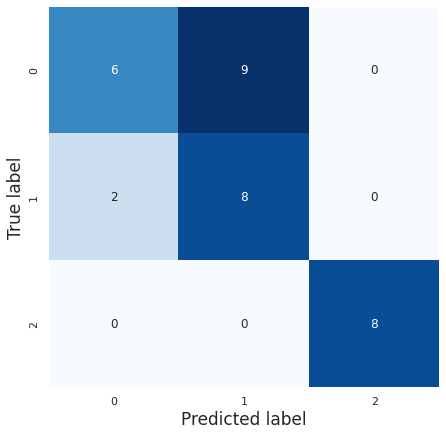

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

model = gnb.fit(x_train, y_train)
#Print the score on the train data

y_out = gnb.predict(x_test) #Predict class or regression value for X.


cm = confusion_matrix(y_test, y_out) #(y_true, y_pred)
figsize = (7,7)
fig = plt.figure(figsize=figsize)
heatmap=sns.heatmap(cm, xticklabels=1, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.ylabel('True label', fontsize=17)
plt.xlabel('Predicted label', fontsize=17)
# heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='center', va='center', fontsize=16)
# heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='center', va='center', fontsize=16)

print("Confusion Matrix:\n",cm)

Score = gnb.score(x_test, y_test)
print("Accuracy Score: ",Score)
#Other option: print("Accuracy: ",metrics.accuracy_score(y_test, y_out))